<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>

<h1 align="center"><font size="5">Supervised Machine Learning: Classification - Final Assignment</font></h1>


# Library Import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV

In [3]:
import warnings

warnings.filterwarnings('ignore')

In [4]:
RANDOM_STATE = 123

# Introduction

The target of this workbook is to create a model that accurately predicts what GPA class a student belongs to based on a number of factors. \

It will also be used to investigate using various techniques to address bias in dataset using class_weights, under sampling and SMOTE.

## Helper Methods

**Metrics Helpers**

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

def get_metrics(y_true, y_pred, target):
    """Returns classification metrics as a dict

    Args:
        y_true (_type_): _description_
        y_pred (_type_): _description_
        target (_type_): _description_

    Returns:
        _type_: _description_
    """
    return {
        'target': target,
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='weighted'),
        'recall': recall_score(y_true, y_pred, average='weighted'),
        'f_score': f1_score(y_true, y_pred, average='weighted')
     #   'auc_score': roc_auc_score(y_true, y_pred, average='weighted', multi_class='ovr')
    }

def print_metrics(df):
    """Prints bar plot of classification metrics for four different models

    Args:
        df (_type_): _description_
    """
    plt.figure(figsize=(12, 10), dpi=80)
    original = df.iloc[0, 1:].values
    class_weight = df.iloc[1, 1:].values
    smote = df.iloc[2, 1:].values
    under = df.iloc[3, 1:].values
    width = 0.2
    x = np.arange(4)
    plt.bar(x-0.2, original, width, color='#95a5a6')
    plt.bar(x, class_weight, width, color='#d35400')
    plt.bar(x+0.2, smote, width, color='#2980b9')
    plt.bar(x+0.4, under, width, color='#3498db')
    plt.xticks(x, ['accuracy', 'precision', 'recall', 'f_score'])
    plt.ylabel('Score')
    plt.legend(df['target'])

**Hyperparameter Tuning Helpers**

In [6]:
from sklearn.model_selection import GridSearchCV


def grid_search_lr(X_train, y_train, class_weights, random_state=RANDOM_STATE):
    """Method which uses GridSearchCV to perform hyperparameter tuning to determine the best class weights to deal with imbalances.

    Args:
        X_train (_type_): _description_
        y_train (_type_): _description_
        class_weights (_type_): _description_
        random_state (_type_, optional): _description_. Defaults to RANDOM_STATE.

    Returns:
        _type_: _description_
    """
    model = LogisticRegressionCV(
        Cs=8,
        cv=5,
        random_state=random_state,
        max_iter=1000,
        solver='liblinear'
    )
    
    param_grid = {
        'penalty': ['l1', 'l2'],
        'class_weight': class_weights
    }
    
    grid_search = GridSearchCV(
        estimator=model,
        scoring='f1_weighted',
        param_grid=param_grid,
        cv=5,
        verbose=True,
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    return grid_search.best_params_

def grid_search_rf(X_train, y_train):
    ...

**Resampling Helper Methods**

In [7]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

def resample(X_train, y_train, random_state=RANDOM_STATE):
    """Returns under and over sampled data

    Args:
        X_train (_type_): _description_
        y_train (_type_): _description_

    Returns:
        _type_: _description_
    """
    smote_sampler = SMOTE(random_state=random_state)
    under_sampler = RandomUnderSampler(random_state=random_state)
    X_smo, y_smo = smote_sampler.fit_resample(X_train, y_train)
    X_under, y_under = under_sampler.fit_resample(X_train, y_train)
    return X_smo, y_smo, X_under, y_under
    

# Dataset Import

* Name: Students Performance Dataset
* Source: kaggle
* Url: https://www.kaggle.com/datasets/rabieelkharoua/students-performance-dataset

In [8]:
student_df = pd.read_csv('student_performance_data.csv')

In [9]:
student_df.head()

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4.0
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3.0
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4.0


In [10]:
student_df.isna().sum()

StudentID            0
Age                  0
Gender               0
Ethnicity            0
ParentalEducation    0
StudyTimeWeekly      0
Absences             0
Tutoring             0
ParentalSupport      0
Extracurricular      0
Sports               0
Music                0
Volunteering         0
GPA                  0
GradeClass           0
dtype: int64

No missing data.

## 1. EDA

### 1.1 Target Class Distribution

In [11]:
Y_COLUMN = 'GradeClass'

Target of this dataset is GradeClass, which is broken down into five classes:

* 0: 'A' (GPA >= 3.5)
* 1: 'B' (3.0 <= GPA < 3.5)
* 2: 'C' (2.5 <= GPA < 3.0)
* 3: 'D' (2.0 <= GPA < 2.5)
* 4: 'F' (GPA < 2.0)

Lets look at the distribution of GradeClass.

In [12]:
student_df[Y_COLUMN].value_counts(normalize=True)

GradeClass
4.0    0.506271
3.0    0.173077
2.0    0.163462
1.0    0.112458
0.0    0.044732
Name: proportion, dtype: float64

<Axes: xlabel='GradeClass'>

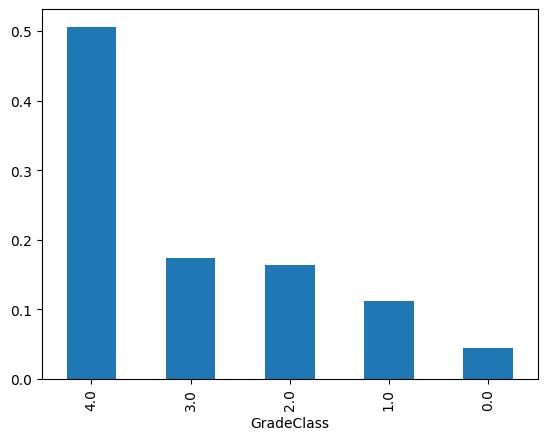

In [13]:
student_df[Y_COLUMN].value_counts(normalize=True).plot.bar()

So we seem to be dealing with an imbalanced dataset, as 50% of the target class have a value of 4, with the rest being fairly evenly distributed around the 20% mark. I will have to review the classification metrics to determine if this needs to be rebalanced.

### 1.2 Feature Distribution

On the outset we can drop StudentID from the features. I will also remove GPA from the features, as it is redundant given that we are trying to predict the class of GPA based on inputs.

In [14]:
FEATURES_TO_IGNORE = set(['StudentID', 'GPA'])

In [15]:
FEATURE_COLUMNS = [colname for colname in student_df.columns if colname != Y_COLUMN and colname not in FEATURES_TO_IGNORE]

In [16]:
student_df[FEATURE_COLUMNS].dtypes

Age                    int64
Gender                 int64
Ethnicity              int64
ParentalEducation      int64
StudyTimeWeekly      float64
Absences               int64
Tutoring               int64
ParentalSupport        int64
Extracurricular        int64
Sports                 int64
Music                  int64
Volunteering           int64
dtype: object

We seem to be dealing with numeric features which is helpful. I'll do a distribution plot to determine if any normalization will be needed.

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Gender'}>,
        <Axes: title={'center': 'Ethnicity'}>],
       [<Axes: title={'center': 'ParentalEducation'}>,
        <Axes: title={'center': 'StudyTimeWeekly'}>,
        <Axes: title={'center': 'Absences'}>],
       [<Axes: title={'center': 'Tutoring'}>,
        <Axes: title={'center': 'ParentalSupport'}>,
        <Axes: title={'center': 'Extracurricular'}>],
       [<Axes: title={'center': 'Sports'}>,
        <Axes: title={'center': 'Music'}>,
        <Axes: title={'center': 'Volunteering'}>]], dtype=object)

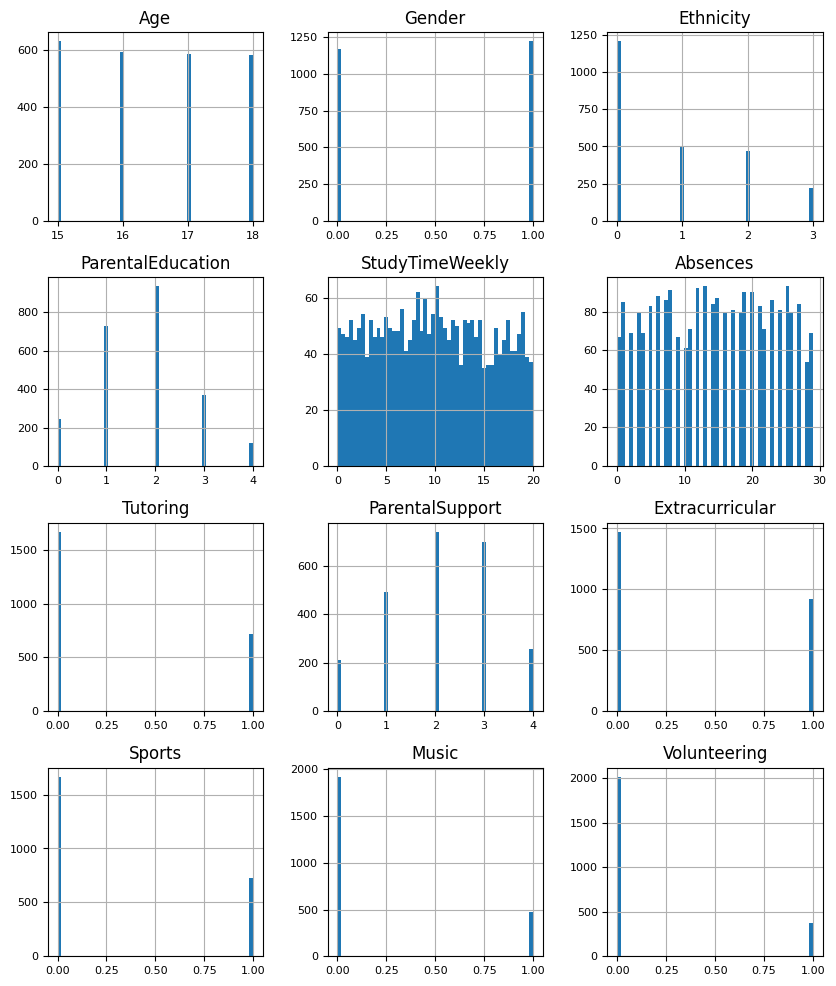

In [17]:
student_df[FEATURE_COLUMNS].hist(figsize=(10, 12), bins=50, xlabelsize=8, ylabelsize=8)

Observations on the features are below:

* The majority are Ordinal or Binary.
* The only Numerical Features appear to be StudyTimeWeekly and Absences. An interesting evaluation point will be whether these can be bucketed like the GPA.
* Numerical values seems to follow normal distribution so don't need to be normalized.

## 2. Train Test Split

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X = student_df[FEATURE_COLUMNS]
y = student_df[Y_COLUMN]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

## 3. Logistic Model Training

### 3.1 Initial Logistic Model Training

In [21]:
lr_model = LogisticRegressionCV(
    Cs=8,
    cv=5,
    class_weight='balanced',
    penalty='l2',
    random_state=RANDOM_STATE,
    max_iter=1000,
    solver='liblinear'
)

In [22]:
lr_model.fit(X_train, y_train)

LogisticRegressionCV(Cs=8, class_weight='balanced', cv=5, max_iter=1000,
                     random_state=123, solver='liblinear')

In [23]:
y_pred = lr_model.predict(X_test)

In [24]:
metrics_lr_orig = get_metrics(y_test, y_pred, 'Logistic Regression')

In [25]:
metrics_lr_orig

{'target': 'Logistic Regression',
 'accuracy': 0.6239554317548747,
 'precision': 0.6615114156207633,
 'recall': 0.6239554317548747,
 'f_score': 0.6318873176947442}

Not bad as a starting point, but lets see if we can improve the metrics by rebalancing the dataset.

### 3.2 Logistic Regression training with Class Weights and Rebalanced Datasets

There are three methods I am going to use in order to address the imbalanced in the datasets:

1. Class Weights
2. SMOTE
3. Under Sampling

I'll comment this out for now as I dont need to keep running it.

In [27]:
lr_model_cw = LogisticRegressionCV(
    Cs=8,
    cv=5,
    class_weight={0: 0.2, 1: 0.2, 2: 0.2, 3: 0.2, 4: 0.2},
    penalty='l2',
    random_state=RANDOM_STATE,
    max_iter=1000,
    solver='liblinear'
)

In [28]:
lr_model_cw.fit(X_train, y_train)

LogisticRegressionCV(Cs=8,
                     class_weight={0: 0.2, 1: 0.2, 2: 0.2, 3: 0.2, 4: 0.2},
                     cv=5, max_iter=1000, random_state=123, solver='liblinear')

In [29]:
y_pred = lr_model_cw.predict(X_test)

In [30]:
metrics_lr_cw = get_metrics(y_test, y_pred, 'LR Model Class Weight')
metrics_lr_cw

{'target': 'LR Model Class Weight',
 'accuracy': 0.6643454038997214,
 'precision': 0.6009880100338665,
 'recall': 0.6643454038997214,
 'f_score': 0.6223915223833467}

In [31]:
X_smo, y_smo, X_under, y_under = resample(X_train, y_train)

Prediction and metrics using SMO

In [32]:
lr_model.fit(X_smo, y_smo)
y_pred_smo = lr_model.predict(X_test)
metrics_lr_smo = get_metrics(y_test, y_pred_smo, 'Logistic Regression SMO')
metrics_lr_smo

{'target': 'Logistic Regression SMO',
 'accuracy': 0.5766016713091922,
 'precision': 0.5840421462653375,
 'recall': 0.5766016713091922,
 'f_score': 0.5725304861229297}

Prediction and metrics using under

In [33]:
lr_model.fit(X_smo, y_smo)
y_pred_smo = lr_model.predict(X_test)
metrics_lr_under = get_metrics(y_test, y_pred_smo, 'Logistic Regression Under')
metrics_lr_under

{'target': 'Logistic Regression Under',
 'accuracy': 0.5766016713091922,
 'precision': 0.5840421462653375,
 'recall': 0.5766016713091922,
 'f_score': 0.5725304861229297}

In [35]:
logistic_metrics = pd.DataFrame([metrics_lr_orig, metrics_lr_cw, metrics_lr_smo, metrics_lr_under])
logistic_metrics

,target,accuracy,precision,recall,f_score
0,Logistic Regression,0.623955,0.661511,0.623955,0.631887
1,LR Model Class Weight,0.664345,0.600988,0.664345,0.622392
2,Logistic Regression SMO,0.576602,0.584042,0.576602,0.572530
3,Logistic Regression Under,0.576602,0.584042,0.576602,0.572530


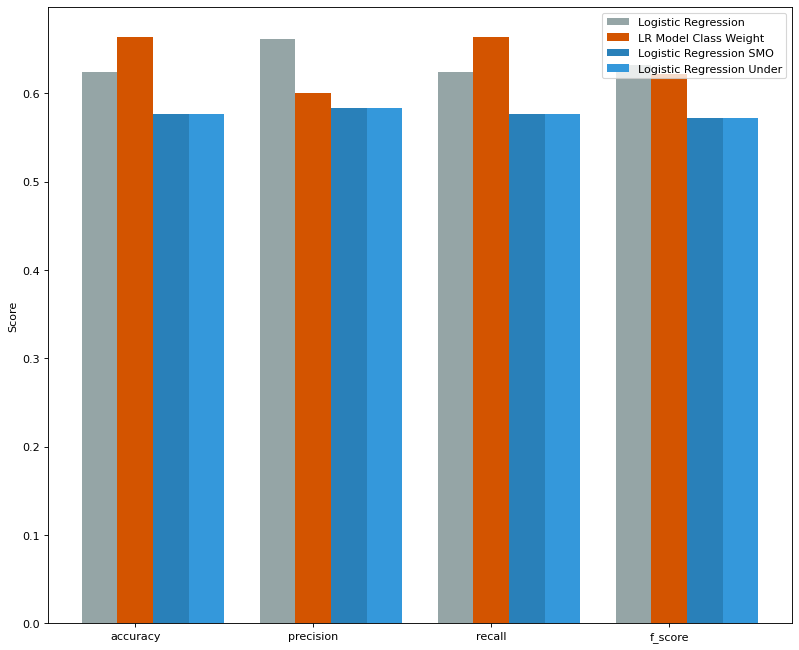

In [36]:
print_metrics(logistic_metrics)

**Observations**

A few observations based on the above:

* Modifying the class weights improved accuracy and recall, but reduced precision and thereby f1_score
* Rebalancing the dataset did not have an impact on model performance, and actually made it worse

**Conclusion**

Even though there are imbalanced in this dataset, it doesn't seem to be impacting model performance (possibly due to Cross Validation being used within the model training). The next step is to train three models with Grid Search hyper parameter tuning; Logistic Regression, Random Forest and XGBoost to determine the most appropriate model.

## 5. Random Forest Training

In [37]:
rf_model_original = RandomForestClassifier(
    random_state=RANDOM_STATE,
)

SyntaxError: invalid syntax (345016730.py, line 4)